# Interpret

## summarize embedding

In [ ]:
# ------------- setting -------------
# preembedding
preembedding_type = 'all_sbert_roberta_nlistsb_encoded'

# trascriptids
transcriptids = []

# choose train/val split
split_window = 'roll-24'

# loss_type
loss_type = 'car_sest'

# define batch_size
batch_size = 1

# print every N batches
print_every = 100


# -------------- load data --------------
# load model
model = CCTransformer(
    d_model=1024, 
    n_layers_encoder=2, n_layers_decoder=2,
    n_head_encoder=8, n_head_decoder=8,
    output_summary=True)

model.load_state_dict(torch.load(f'./data/models/model-{split_window}-{loss_type}-{preembedding_type}.pt'))
_ = model.eval()


# load train/test splits
split_df = pd.read_csv(f'{DATA_DIR}/split_dates.csv')

# load preembeddings
if 'preembeddings' not in globals():
    print(f'Loading preembeddings...{Now()}')
    preembeddings = torch.load(f'{DATA_DIR}/embeddings/preembeddings_{preembedding_type}.pt')
    print(f'Loading finished.')
    
# load targets_df
if 'targets_df' not in globals():
    targets_df_path = f'{DATA_DIR}/f_sue_keydevid_car_finratio_transcriptid_text.feather'
    targets_df = pd.read_feather(targets_df_path)

# ------------ create Dataset & DataLoader ----------
# create Dataset
ds = {split_type: CCDataset(preembeddings, targets_df, split_window, split_type)
      for split_type in ['train', 'test']}

# create DataLoader
dl = {split_type: DataLoader(ds[split_type], batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, pin_memory=True)
      for split_type in ['train', 'test']}

train_dl = dl['train']
eval_dl = dl['test']

# -------------- forward -----------------------
y_sues, y_cars, y_seleads = [], [], []
t_sues, t_cars, t_seleads = [], [], []

x_expert_summary = {}
x_nonexpert_summary = {}

with torch.no_grad():
    for batch_i, (batch_transcriptids, embeddings, mask, suelag, sue, carlag, car, se, selead, sestlag, sest) in enumerate(tqdm(eval_dl)):
        # get batch size
        bsz = sue.size(0)

        # create query
        query_sue = suelag.unsqueeze(-1).unsqueeze(-1) # (N, 1, 1)
        query_car = carlag.unsqueeze(-1).unsqueeze(-1) # (N, 1, 1)
        query_selead = se.unsqueeze(-1).unsqueeze(-1) # (N, 1, 1)
        query_sest = sestlag.unsqueeze(-1).unsqueeze(-1) # (N, 1, 1)

        # query_sue = torch.ones(bsz, 1, 1) # (N, 1, 1)
        # query_car = torch.ones(bsz, 1, 1) # (N, 1, 1)
        # query_selead = torch.ones(bsz, 1, 1) # (N, 1, 1)
        # query_sest = torch.ones(bsz, 1, 1) # (N, 1, 1)

        # forward
        # y_sue, y_car, y_selead, y_sest, dist = model(embeddings, mask, query_sue, query_sue, 
                                                     # query_selead, query_sest, output_summary=True)
        # y_sues.extend(y_sue.to(cpu))
        # y_cars.extend(y_car.to(cpu))
        # y_seleads.extend(y_selead.to(cpu))
        
        # t_sues.extend(sue.to(cpu))
        # t_cars.extend(car.to(cpu))
        # t_seleads.extend(selead.to(cpu))
            
        # forward
        out = model(embeddings, mask, query_sue,
                    query_sue, query_selead, query_sest)  
        
        # save summary embeddings
        for i in range(batch_size):
            x_expert_summary[batch_transcriptids[i]] = out['x_expert_summary'][i]
            x_nonexpert_summary[batch_transcriptids[i]] = out['x_nonexpert_summary'][i]

In [175]:
assert x_expert_summary.keys() == x_nonexpert_summary.keys()
keys = list(x_expert_summary.keys())
keys[:3]
x_expert_summary[keys[0]]
x_nonexpert_summary[keys[0]]

[1611911, 1627264, 1579394]

tensor([-0.1774,  0.2405, -0.0230,  ...,  1.3183, -0.3227,  0.2266])

tensor([ 0.5563, -0.6105, -0.9750,  ...,  0.6269, -0.3006,  0.1864])

In [172]:
df = pd.DataFrame({'x_expert_summary': x_expert_summary,
                   'x_nonexpert_summary': x_nonexpert_summary})
df.loc[1611911]

x_expert_summary       [tensor(-0.1774), tensor(0.2405), tensor(-0.02...
x_nonexpert_summary    [tensor(0.5563), tensor(-0.6105), tensor(-0.97...
Name: 1611911, dtype: object

In [310]:
targets_df.keys()

Index(['gvkey', 'permno', 'datadate', 'fyear', 'fqtr', 'ciq_release_date',
       'ciq_call_date', 'rdq', 'rdq1', 'repdats', 'leadrdq1',
       'release_keydevid', 'call_keydevid', 'transcriptid', 'mcap', 'sue',
       'sue_lag1', 'sue_lead1', 'se', 'se_lag1', 'se_lead1', 'sest',
       'sest_lag1', 'sest_lead1', 'car_m1_m1', 'car_m2_m2', 'car_m30_m3',
       'car_0_1', 'car_0_30', 'car_0_30_lag1', 'bm', 'roa', 'debt_asset',
       'alpha', 'beta_mktrf', 'beta_smb', 'beta_hml', 'volatility',
       'text_present', 'text_qa', 'text_ans', 'text_ques', 'text_all'],
      dtype='object')

In [348]:
df = targets_df[['transcriptid', 'mcap', 'bm', 'roa', 'beta_mktrf', 'beta_smb', 'beta_hml', 'alpha']]
mcap = [df[df.transcriptid==tid]['mcap'].values[0] for tid in x_expert_summary]
bm = [df[df.transcriptid==tid]['bm'].values[0] for tid in x_expert_summary]
roa = [df[df.transcriptid==tid]['roa'].values[0] for tid in x_expert_summary]
beta_mktrf = [df[df.transcriptid==tid]['beta_mktrf'].values[0] for tid in x_expert_summary]
beta_smb = [df[df.transcriptid==tid]['beta_smb'].values[0] for tid in x_expert_summary]
beta_hml = [df[df.transcriptid==tid]['beta_hml'].values[0] for tid in x_expert_summary]
alpha = [df[df.transcriptid==tid]['alpha'].values[0] for tid in x_expert_summary]

In [156]:
# reduce dimemsion
from sklearn import manifold, datasets

def reduce_dim(x, dim):
    x = np.array([v.numpy() for k, v in x.items()])
    x -= x.mean(axis=0)
    
#     U, s, V = np.linalg.svd(x, full_matrices=False)
#     x = np.dot(U, np.diag(s))[:,:50]
    
    tsne = manifold.TSNE(n_components=dim, init='pca', random_state=42, perplexity=500,
                         n_iter=5000, learning_rate=500)
    x = tsne.fit_transform(x)
     
    return x

exp2 = reduce_dim(x_expert_summary, 2)
nonexp2 = reduce_dim(x_nonexpert_summary, 2)

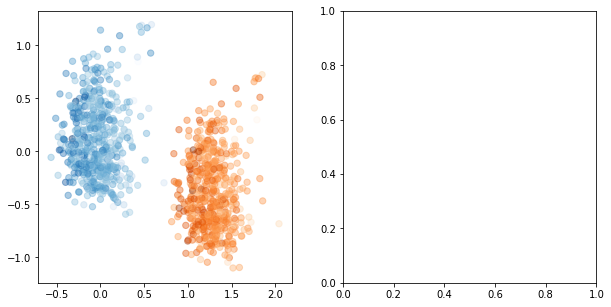

In [355]:
# plot 
import matplotlib
import matplotlib.cm as cm


fig, subplots = plt.subplots(1,2, figsize=(10, 5))

ax = subplots[0]

ax.scatter(exp2[:,0], exp2[:,1], s=40, c=beta_hml, cmap='Blues', alpha=0.4);
ax.scatter(nonexp2[:,0], nonexp2[:,1], s=40, c=beta_hml, cmap='Oranges', alpha=0.4);


ax2 = subplots[1]

def render2d():
    for i, (e, ne) in enumerate(zip(exp2, nonexp2)):
#         if i>=100: break
        ax2.plot([e[0],ne[0]], [e[1], ne[1]], 'k-', linewidth=0.3)
# render2d();